In [0]:
import os

In [30]:
os.environ['KAGGLE_USERNAME'] = 'brainmentors'
os.environ['KAGGLE_KEY'] = '2a3bad949491046bcee14347c0e815d9'

!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [31]:
!unzip gtsrb-german-traffic-sign.zip

Archive:  gtsrb-german-traffic-sign.zip
replace Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Meta.csv                
replace Meta/.~lock.ClassesInformation.ods#? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Meta/.~lock.ClassesInformation.ods#  
replace Meta/.~lock.ClassesInformationStrong.ods#? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Meta/.~lock.ClassesInformationStrong.ods#  
replace Meta/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('Train.csv')

In [34]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [0]:
img = Image.open(df['Path'][100])

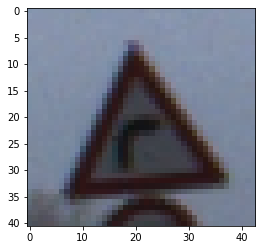

In [36]:
plt.imshow(img)

In [0]:
train_images = []
train_labels = []

for i in range(len(df)):
  img = Image.open(df['Path'].iloc[i])
  img = img.resize((32,32))
  train_images.append(np.array(img))
  train_labels.append(df['ClassId'].iloc[i])

In [38]:
len(train_images)

39209

In [0]:
test_df = pd.read_csv('Test.csv')

In [0]:
test_images = []
test_labels = []

for i in range(len(test_df)):
  img = Image.open(test_df['Path'].iloc[i])
  img = img.resize((32,32))
  test_images.append(np.array(img))
  test_labels.append(test_df['ClassId'].iloc[i])

In [41]:
len(test_df)

12630

In [0]:
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

In [43]:
train_images.shape

(39209, 32, 32, 3)

In [44]:
train_labels[:5]

[20, 20, 20, 20, 20]

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
enc = OneHotEncoder()

train_labels = np.reshape(train_labels, (-1,1))
test_labels = np.reshape(test_labels, (-1,1))

train_labels = enc.fit_transform(train_labels).toarray()

In [0]:
test_labels = enc.fit_transform(test_labels).toarray()

In [48]:
train_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import Model

In [0]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [0]:
train_df = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).batch(32)

In [52]:
train_df

<BatchDataset shapes: ((None, 32, 32, 3), (None, 43)), types: (tf.float64, tf.float64)>

In [0]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, padding = 'same', activation = 'relu')
    self.pool1 = MaxPool2D((2,2))
    self.conv2 = Conv2D(32, 3, padding = 'same', activation = 'relu')
    self.pool2 = MaxPool2D((2,2))
    self.flatten = Flatten()
    self.dense1 = Dense(256, activation = 'relu')
    self.dense2 = Dense(128, activation = 'relu')
    self.dense3 = Dense(43, activation = 'softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)

    return x

In [0]:
model = MyModel()

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_acc')

In [0]:
@tf.function
def train_step(images,labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients((zip(gradients, model.trainable_variables)))
  train_loss(loss)
  train_accuracy(labels, predictions)

In [57]:
epochs = 5
for epoch in range(epochs):
  for images, labels in train_df:
    train_step(images, labels)

  model.save_weights('/content', save_format='tf')
  print("Epochs : , Loss : {}, Accuracy : {}".format(epoch, train_loss.result(), train_accuracy.result()))
  train_loss.reset_states()
  train_accuracy.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epochs : , Loss : {}, Accuracy : {} 0 tf.Tensor(0.913949, shape=(), dtype=float32) tf.Tensor(0.73243386, shape=(), dtype=float32)
Epochs : , Loss : {}, Accuracy : {} 1 tf.Tensor(0.120511726, shape=(), dtype=float32) tf.Tensor(0.964651, shape=(), dtype=float32)
Epochs : , Loss : {}, Accuracy : {} 2 tf.Tensor(0.05569578, shape=(), dtype=float32) tf.Tensor(0.9839833, shape=(), dtype=float32)
Epochs : , Loss : {}, Accuracy : {} 3 tf.Tensor(0.035362884, shape=(), dtype=float32) tf.Tensor(0.98931366, shape=()

In [0]:
prediction = np.argmax(model(test_images), axis=1)

In [59]:
prediction[0]

16

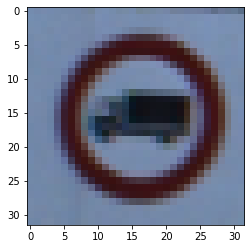

In [60]:
plt.imshow(test_images[0])

In [62]:
np.argmax(test_labels[0])

16